In [ ]:
#https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede
# modification with GRU instead of bilstm

In [ ]:
!pip install tensorflow==1.15.5

     |████████████████████████████████| 110.5 MB 764 bytes/s 
     |████████████████████████████████| 503 kB 43.4 MB/s 
     |████████████████████████████████| 2.9 MB 47.5 MB/s 
     |████████████████████████████████| 3.8 MB 40.6 MB/s 
     |████████████████████████████████| 20.1 MB 12.3 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=21a93c581ed81d8b321f8f3d620f9492e59babe6e331bc6c7d39fb75c4d94977
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv(r'/content/gdrive/My Drive/NER_data/kaggle/ner_dataset.csv', encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [ ]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [ ]:
tags = sorted(list(set(data["Tag"].values)))
tags.remove('O')
tags.insert(0, 'O')
n_tags = len(tags)
n_tags

17

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences = getter.sentences
print(len(sentences))

47959


In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


In [ ]:
def pad_sentence(seq, max_len):
  new_seq = []
  for i in range(max_len):
    try:
      new_seq.append(seq[i])
    except:
      new_seq.append("PADword")
  return new_seq

In [ ]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = pad_sentence(seq, max_len)
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
index2tags = {i:t for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 4,  0,  0,  7, 15, 15, 15,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
# import json
# json.dump(index2tags, open(r'/content/gdrive/My Drive/NER_models/bilstm_elmo_tutorial_index2tags.json', 'w', encoding='utf-8'))

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [ ]:
sess = tf.compat.v1.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

    # return elmo_model.signatures["default"](tf.constant(x))["elmo"]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, GRU

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x = GRU(256,  return_sequences=True)(embedding)
# x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(x)
# x = Add()([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input_text, out)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
from tensorflow.python.keras.utils.vis_utils import plot_model

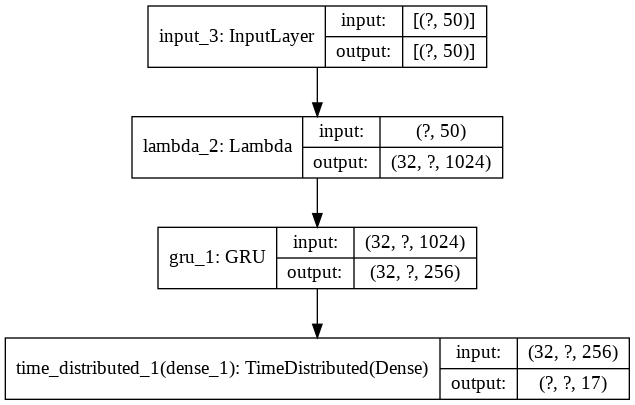

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
len(X_tr)

43163

In [ ]:
# X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
# y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]

X_tr, X_val = X_tr[:100*batch_size], X_tr[-50*batch_size:]
y_tr, y_val = y_tr[:100*batch_size], y_tr[-50*batch_size:]
y_tr.shape

(3200, 50)

In [ ]:
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_tr.shape

(3200, 50, 1)

In [ ]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Train on 3200 samples, validate on 1600 samples
Epoch 1/3
3200/3200 [==============================] - 1556s 486ms/sample - loss: 0.1808 - acc: 0.9562 - val_loss: 0.0729 - val_acc: 0.9803
Epoch 2/3
3200/3200 [==============================] - 1557s 487ms/sample - loss: 0.0655 - acc: 0.9815 - val_loss: 0.0611 - val_acc: 0.9827
Epoch 3/3
3200/3200 [==============================] - 1535s 480ms/sample - loss: 0.0522 - acc: 0.9846 - val_loss: 0.0595 - val_acc: 0.9830


In [ ]:
# This does not work!!!
# with tf.device('gpu'):
#   history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16000 samples, validate on 3200 samples


InvalidArgumentError: ignored

In [ ]:
model.save(r'/content/gdrive/My Drive/NER_models/gru_256_elmo')

In [ ]:
X_te[0]

['They',
 'say',
 'the',
 'documents',
 'were',
 'found',
 'in',
 'the',
 'computer',
 'of',
 'FARC',
 'leader',
 'Raul',
 'Reyes',
 'during',
 'a',
 'cross-border',
 'raid',
 'in',
 'Ecuador',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [ ]:
pred = model.predict(np.array(X_te[:32]))

In [ ]:
pred_argmax = np.argmax(pred, axis = 2)

In [ ]:
for i in range(10):
  for token, label, label_pred in zip(X_te[i], y_te[i], list(pred_argmax[i])):
    if token != 'PADword':
      print(token, label, index2tags[label], label_pred, index2tags[label_pred])

They 0 O 0 O
say 0 O 0 O
the 0 O 0 O
documents 0 O 0 O
were 0 O 0 O
found 0 O 0 O
in 0 O 0 O
the 0 O 0 O
computer 0 O 0 O
of 0 O 0 O
FARC 6 B-org 6 B-org
leader 0 O 0 O
Raul 7 B-per 7 B-per
Reyes 15 I-per 15 I-per
during 0 O 0 O
a 0 O 0 O
cross-border 0 O 0 O
raid 0 O 0 O
in 0 O 0 O
Ecuador 3 B-geo 3 B-geo
last 0 O 0 O
month 0 O 0 O
. 0 O 0 O
Iran 3 B-geo 3 B-geo
says 0 O 0 O
its 0 O 0 O
nuclear 0 O 0 O
program 0 O 0 O
is 0 O 0 O
for 0 O 0 O
peaceful 0 O 0 O
purposes 0 O 0 O
only 0 O 0 O
. 0 O 0 O
A 0 O 0 O
statement 0 O 0 O
from 0 O 0 O
the 0 O 0 O
medical 0 O 0 O
center 0 O 0 O
in 0 O 0 O
Cleveland 3 B-geo 3 B-geo
says 0 O 0 O
Mr. 7 B-per 7 B-per
Carter 15 I-per 15 I-per
left 0 O 0 O
the 0 O 0 O
hospital 0 O 0 O
after 0 O 0 O
midday 8 B-tim 8 B-tim
Thursday 16 I-tim 16 I-tim
. 0 O 0 O
Speaking 0 O 0 O
to 0 O 0 O
the 0 O 0 O
Daily 6 B-org 6 B-org
Star 14 I-org 14 I-org
newspaper 0 O 0 O
, 0 O 0 O
photographer 0 O 0 O
Ian 7 B-per 7 B-per
Whittaker 15 I-per 15 I-per
said 0 O 0 O
the 0 O